# Use case: masked arrays, multi-band photometry

This notebook presents a more advanced used of the `isophote` package. If you didn't read the other notebboks and are not familiar with this kind of analysis, we recommend you do so before tackling this script. 

In this example, we want to build color profiles by running `ellipse` on an image, and then, using the isophotes so derived, to get isophotes on another image of the same object in a different spectral band.

In this example we use public domain images of NGC1068 from the Hubble Space Telescope archive (https://www.spacetelescope.org/projects/fits_liberator/ngc1068data/). 

One of them is a wide-band ~R image, the other is a narrow-band H$\alpha$ + [NII]. Due to the detector shapes, the image frames do not contain meaningful information everywhere; some regions have to be masked out. The `isophote` package can handle numpy masked arrays, thus we build masked image frames before submitting then for analysis.

Note that the use of masked arrays slows down the computations by a significant amount.

We use the higher S/N wide band image to fit the isophotes; then, loop over the geometry of these isophotes to extract samples from the narrow-band, lower S/N image, without fitting. This should minimize fitting problems caused by the lumpiness and lower S/N of the narrow-band image. 

### 1 - Read images and mask out unwanted regions

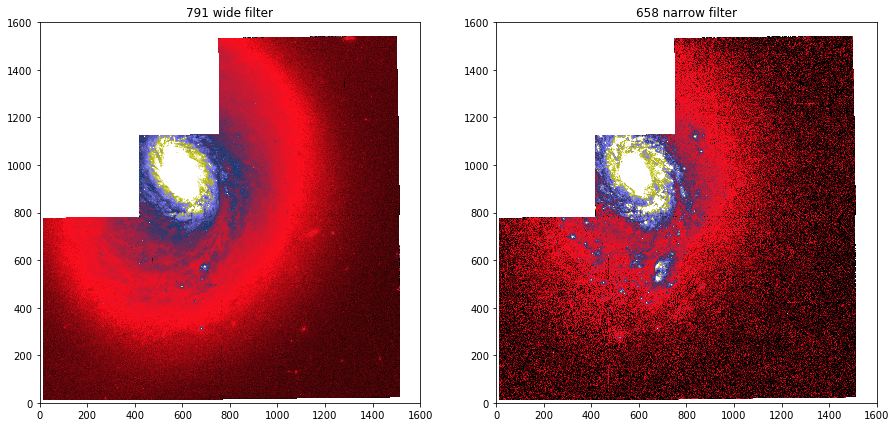

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

# This was copied from the astropy-tutorials/Contributing.md file,
# but doesn't work (generates a 'unknown url' error).
# tutorialpath = ''
# 791wmos = download_file(tutorialpath + '791wmos.fits', cache=True)
# image = fits.open(791wmos)
image = fits.open('791wmos.fits')
pixel_data_791 = image[0].data
image = fits.open('658nmos.fits')
pixel_data_658 = image[0].data

# build numpy masked arrays. In these images, pixels with
# no information in then are signaled by the value zero.
import numpy as np
import numpy.ma as ma
pixel_data_658 = ma.masked_equal(pixel_data_658, np.zeros(shape=pixel_data_658.shape))
pixel_data_791 = ma.masked_equal(pixel_data_791, np.zeros(shape=pixel_data_791.shape))

# visually inspect the images.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
limits = [0,1600]
ax1.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title("791 wide filter")
ax2.imshow(pixel_data_658, cmap=cm.gist_stern, vmin=0, vmax=50)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title("658 narrow filter")

### 2 - Start a basic fitting procedure on wide-band image

This usually requires some trial and error in order to evaluate the abilities of the algorithms regarding the particular image being analysed. In this case, we want to see how far out on the wide-band galaxy image the ellipse fitting algorithm will go before significance is lost.

In [ ]:
from photutils.isophote.geometry import Geometry
from photutils.isophote.ellipse import Ellipse

# we start with first guesses for the geometry parameters
# gleaned from visual inspection of the image itself.
x0 = 600.    # center position
y0 = 970.    # center position
sma = 100.   # starting semi-major axis length in pixels
eps = 0.3    # ellipticity
pa = 120. / 180. * np.pi # position angle

g = Geometry(x0, y0, sma, eps, pa)
ellipse = Ellipse(pixel_data_791, geometry=g)

Centering on object....   Done. Found x0 = 605.0, y0 = 965.0


For the actual fit we use default parameter values, except that we use 'median' integration mode, sigma-clipping of the integrated values, and a more lax criterion for the flagged data points. This choice of parameters should probably decrease the influence of bright starts and HII regions on the basically elliptical underlying light distrubution. And also allow ellipses be fitted even thoug we have large regions masked out from the image.

In [ ]:
w_list = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.3,)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
 100.00      505.30 ( 6.75)  0.383 (0.002) 110.24 ( 0.2)  0.135   105     1   20     0
 110.00      466.60 ( 6.66)  0.405 (0.002) 110.24 ( 0.2)  0.123   107     1   10     0
 121.00      377.67 ( 4.95)  0.333 (0.003) 127.48 ( 0.3)  0.141   120     2   10     0
 133.10      361.26 ( 3.50)  0.390 (0.002) 128.14 ( 0.1)  0.112   115     4   10     0
 146.41      290.61 ( 3.72)  0.320 (0.002) 125.42 ( 0.2)  0.086   124     3   10     0
 161.05      237.69 ( 3.21)  0.319 (0.001) 127.49 ( 0.1)  0.074   127     0   10     0
 177.16      194.96 ( 3.06)  0.341 (0.001) 129.03 ( 0.1)  0.063   119     8   10     0
 194.87      142.93 ( 2.33)  0.350 (0.002) 126.40 ( 0.2)  0.115   112    15   10     0
 214.3

/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 259.37       88.26 ( 1.82)  0.314 (0.018) 115.77 ( 1.0)  0.219    79    48    3     5


Note that the fit won't proceed beyond `sma~240`. Something in the image there prevents the algorithm to ever find a satisfactory solution. 

Lets plot some isophotes on top of the image:

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=1200)
ax.set_xlim([300,900])
ax.set_ylim([700,1200])
ax.set_title("791 wide filter")

# go to the outermost successfully fitted ellipse at sma=235
for sma in [50.,100.,150.,200.,235.]:
    iso = w_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='w')

Lets plot some samples:

In [ ]:
plt.figure(figsize=(10, 3))
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")
for sma,color in zip([100.,150.,230.],['r','g','b']):
    iso = w_list.get_closest(sma)
    plt.scatter((iso.sample.values[0]+iso.sample.geometry.pa)/np.pi*180., iso.sample.values[2], color=color)

These suggest that the basic elliptical component of the light distribution was accounted for by the fit. No significant first or second order harmonics seem to be present. The remaining oscillations in these residuals are a sign of non-elliptical components still remaining in the image, as expected from such galaxy.

### 3 - Fit outer regions of the galaxy

From the image display we can see that there is still plenty of signal outside `sma=235` to perform reasonable fits. In a situation like this, we can try to resume the fit past the problematic region. We run the fit from a new instance of class `Ellipse`, initialized with geometry parameters gleaned visualy form the outer regions of the galaxy. We also use a larger `step` parameter so as to increase the distance between successive ellipses. This has the benefit of increasing the areas of integration used to extract each data point along a elliptical path, thus improving the S/N ratio. 

In [ ]:
x0 = 600. 
y0 = 970.
sma = 300. # start from here, and use this as the minimum sma to fit as well.
eps = 0.2
pa = 70. / 180. * np.pi
g = Geometry(x0, y0, sma, eps, pa)
ellipse = Ellipse(pixel_data_791, geometry=g)
w_list_outer = ellipse.fit_image(integrmode='median',step=0.3,minsma=300.,maxsma=1000.,fflag=0.3,sclip=3.0,nclip=3)

The fit went well down to the edge of the usable data. Comparing the isophote plots below with the plots for the inner region, we can see that there seems to be a sudden change in geometry at around `sma~230`. Ellipses get flatter and the position angle twists by a significant amount at that region, which may explain why the fit there was problematic at the first run.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title("791 wide  filter, outer regions")
for sma in [230.,300.,400.,500.,700.,900.]:
    iso = w_list_outer.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')

The plot below also confirms that the fit went well. There is no suggestion that strong first and second harmonics are present after the fit.

In [ ]:
plt.figure(figsize=(10, 3))
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")
for sma,color in zip([300.,400.,500.,700.,900.],['r','g','b','y','m']):
    iso = w_list_outer.get_closest(sma)
    plt.scatter((iso.sample.values[0]+iso.sample.geometry.pa)/np.pi*180., iso.sample.values[2], color=color)

### 4 - Combine results from inner and outer regions

Now we merge results from the two fits into a single instance of `IsophoteList`. At the same time, we discard the bad fits.

In [ ]:
from photutils.isophote.isophote import IsophoteList 

w_list_combined = IsophoteList(w_list[7:-5])

print(type(w_list_combined))
for iso in w_list_combined:
    print(iso)
print(w_list_combined.sma)